## Imports and Data Setup

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [8]:
cyberiot = pd.read_csv(r"C:/Users/shahn/OneDrive/Desktop/CODE_Intrusion_Detection_2024/IoT_Intrusion.csv")

In [9]:
# load data file
intru_table = pd.read_csv("C:/Users/shahn/OneDrive/Desktop/CODE_Intrusion_Detection_2024/IoT_Intrusion.csv")
intru_labels_removed = intru_table.drop(columns=['label'])

## Data Preprocessing

In [10]:
# save attribute and label strings
all_attribute_names = intru_table.columns.drop('label')

intru_label_names = ['Backdoor_Malware', 'BenignTraffic', 'BrowserHijacking', 'CommandInjection', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'DDoS-ICMP_Fragmentation',
                     'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation',
                     'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood',
                     'Mirai-udpplain', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PingSweep', 'Recon-PortScan', 'SqlInjection', 'Uploading_Attack', 'VulnerabilityScan', 'XSS']

In [11]:
# complete one-hot encoding on intrusion labels
ohe = OneHotEncoder()
ohe_intru_labels = pd.DataFrame(ohe.fit_transform(intru_table['label'].values.reshape(-1,1)).toarray(), columns=intru_label_names)

In [12]:
# we decided to remove the following attributes since they provide no meaningful contributions to the model
exclude = ['ece_flag_number', 'cwr_flag_number', 'SMTP', 'Telnet', 'IRC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'Covariance', 'Variance']

relevant = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
         'syn_count', 'fin_count', 'urg_count', 'rst_count', 'IPv', 'LLC', 'DNS', 'SSH', 'TCP', 'UDP',
         'DHCP', 'ARP', 'ICMP', 'IAT', 'Number', 'Mangitue', 'Radius', 'Weight']

# remove unwanted data attribute columns
attribute_data = intru_labels_removed.drop(columns=exclude)

# split data for all model runs
X_train, X_test, y_train, y_test = train_test_split(attribute_data, ohe_intru_labels, train_size=0.9, random_state=5)

In [13]:
# check if each attribute is normally distributed
for col_name in attribute_data:
    print(col_name, shapiro(attribute_data[col_name]), "\n\tmin:", np.min(attribute_data[col_name]), "; max:", np.max(attribute_data[col_name]))

flow_duration ShapiroResult(statistic=0.003912689874606579, pvalue=3.287366402848467e-239) 
	min: 0.0 ; max: 99435.76178
Header_Length ShapiroResult(statistic=0.15595012723912527, pvalue=1.657367141034325e-232) 
	min: 0.0 ; max: 9815555.0
Protocol Type ShapiroResult(statistic=0.6352051479259249, pvalue=4.925866299250941e-200) 
	min: 0.0 ; max: 47.0
Duration ShapiroResult(statistic=0.18466471163268572, pvalue=4.0550473173632e-231) 
	min: 0.0 ; max: 255.0
Rate ShapiroResult(statistic=0.05924111192858483, pvalue=6.924870220670144e-237) 
	min: 0.0 ; max: 7340032.0
Srate ShapiroResult(statistic=0.05924111192858483, pvalue=6.924870220670144e-237) 
	min: 0.0 ; max: 7340032.0
Drate ShapiroResult(statistic=9.673064369997153e-05, pvalue=2.2960230502648243e-239) 
	min: 0.0 ; max: 0.848465429
fin_flag_number ShapiroResult(statistic=0.3146954186658635, pvalue=3.2703875468487175e-224) 
	min: 0 ; max: 1
syn_flag_number ShapiroResult(statistic=0.49781337233979617, pvalue=4.072253047902139e-212) 
	min:

In [14]:
# attributes are NOT normally distributed (all p-values < 0.05) - normalize traffic attribute data in train and test sets
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=attribute_data.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=attribute_data.columns)

## Data Visualization

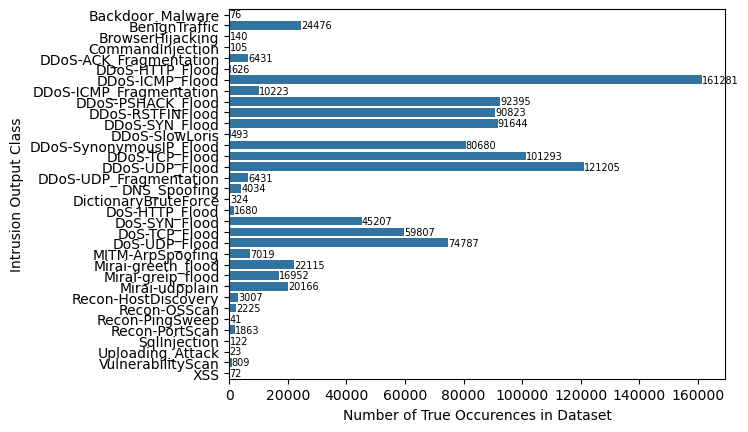

In [15]:
# show output class distribution
classes_true_count = []
for col in ohe_intru_labels:
    count = (ohe_intru_labels[col] == 1).sum()
    classes_true_count.append(count)
class_distru = pd.DataFrame({'Intrusion Output Class': ohe_intru_labels.columns, 'Number of True Occurences in Dataset': classes_true_count})
fig, ax = plt.subplots()
sns.barplot(x='Number of True Occurences in Dataset', y='Intrusion Output Class', data=class_distru)
for i in ax.containers:
    ax.bar_label(i, fontsize=7)

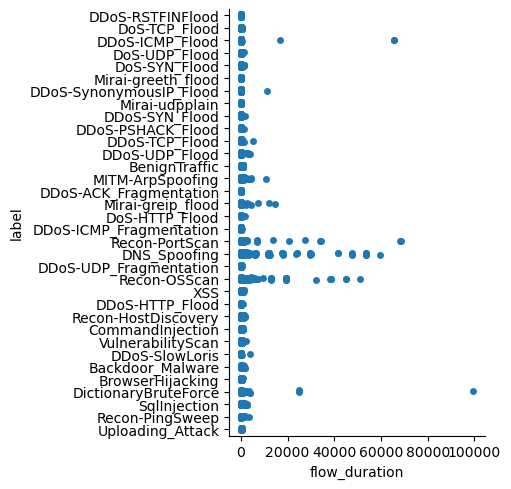

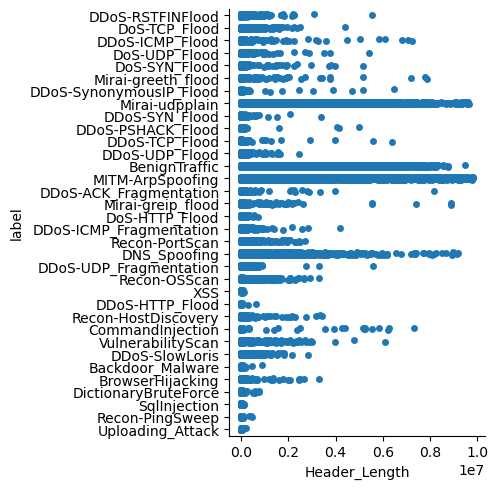

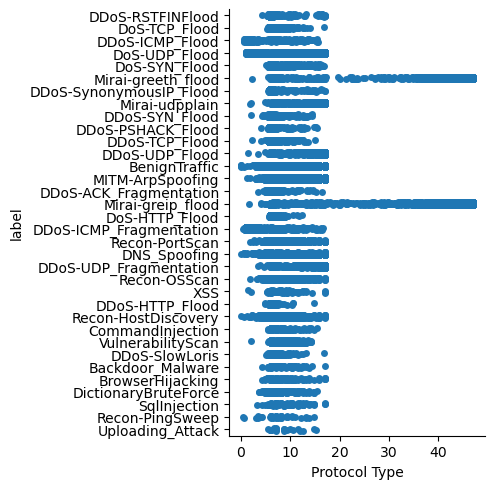

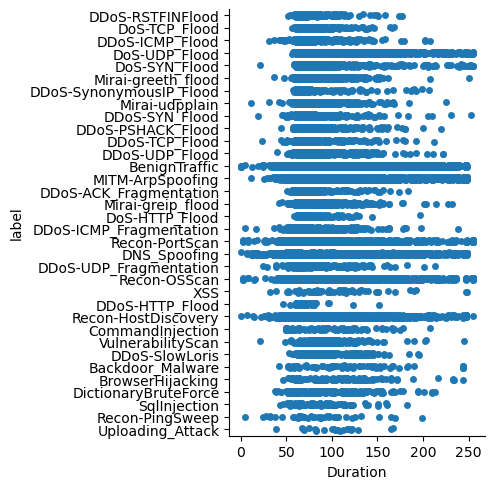

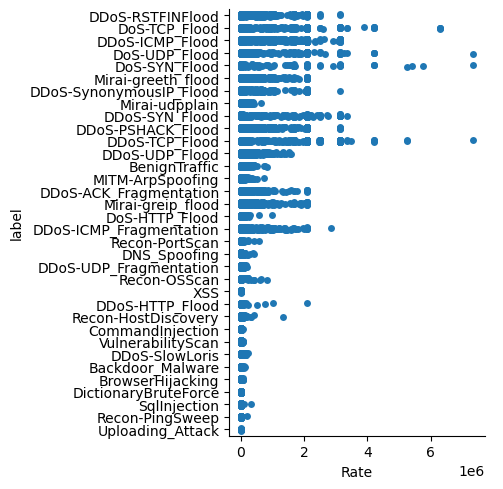

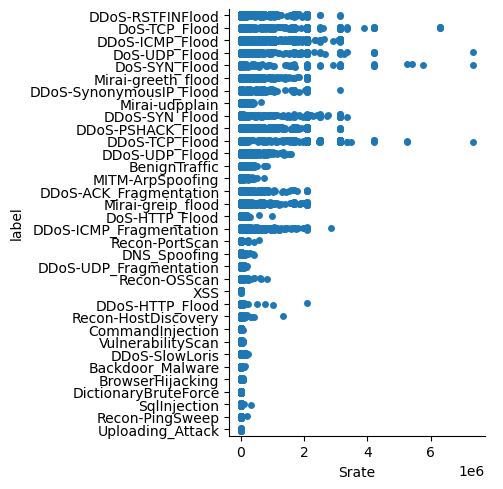

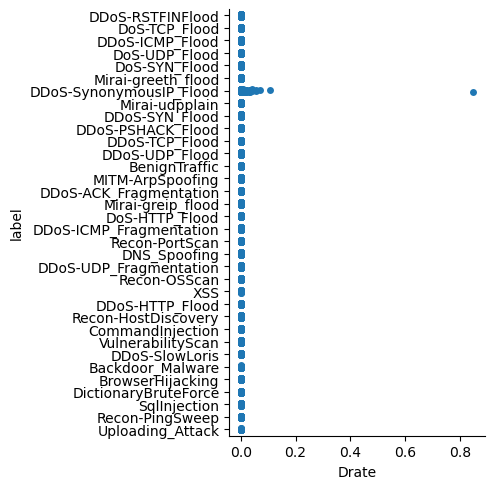

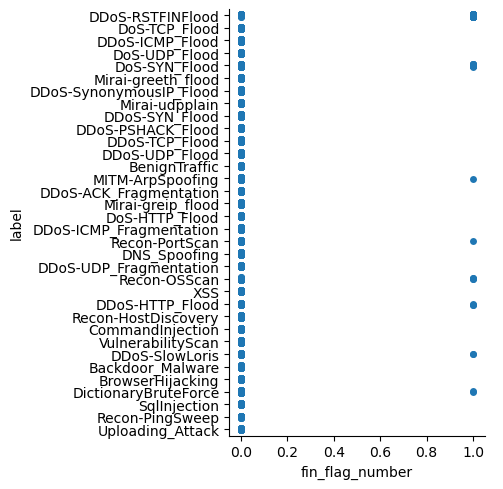

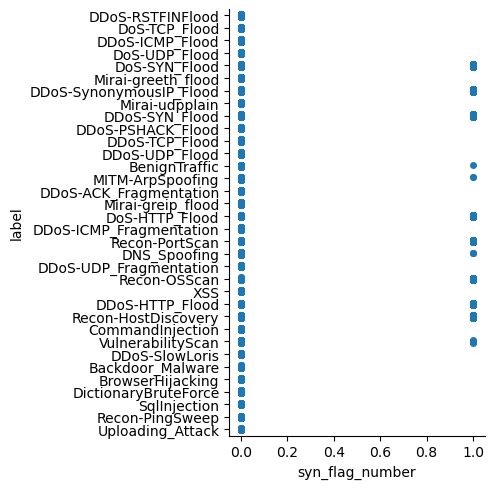

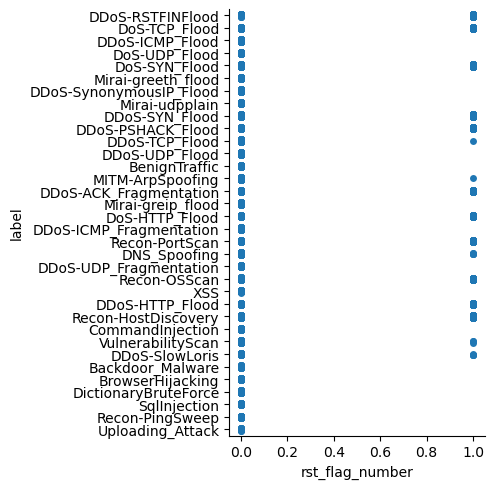

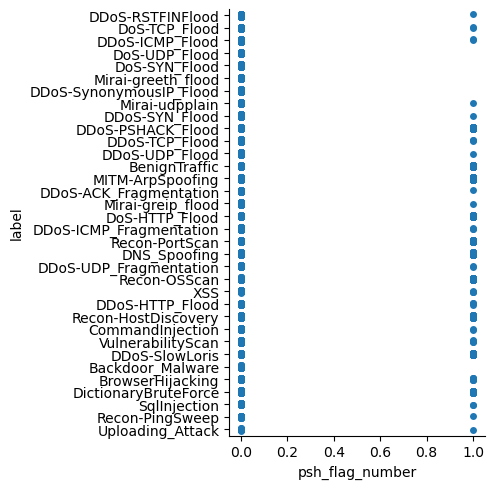

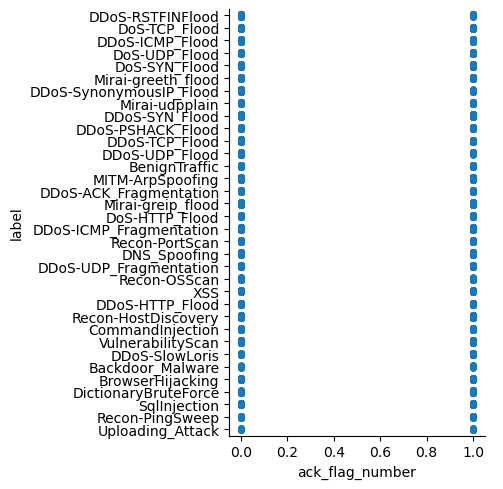

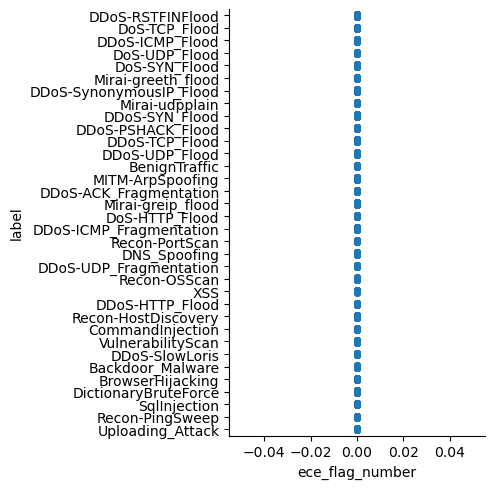

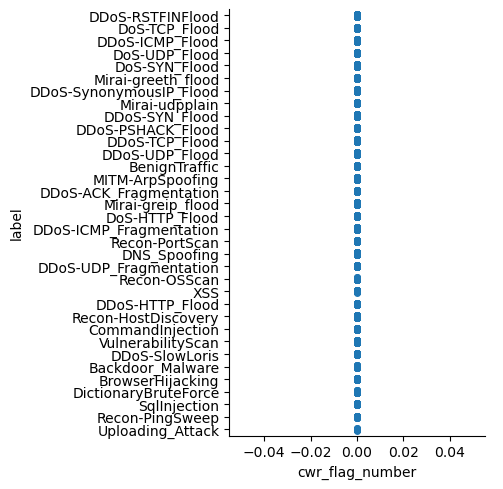

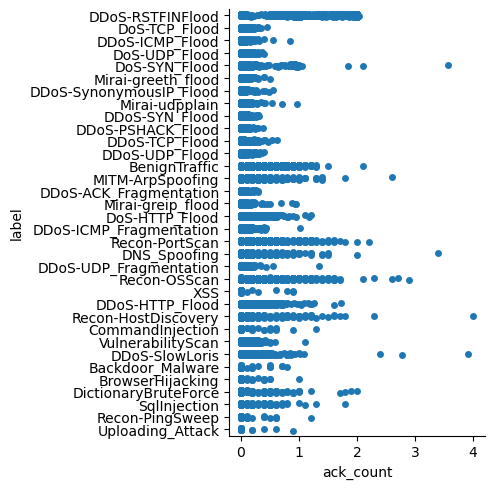

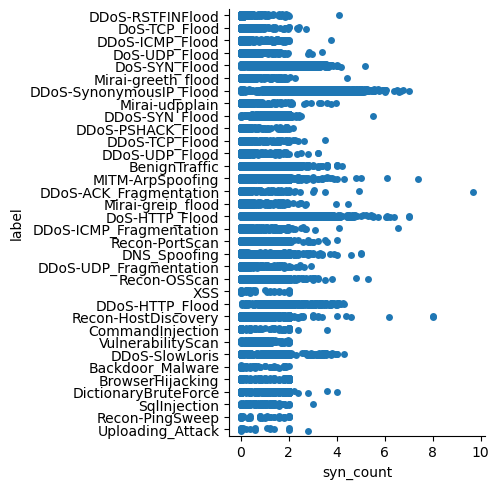

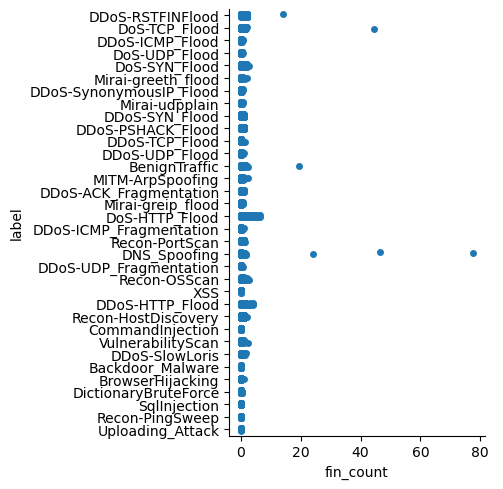

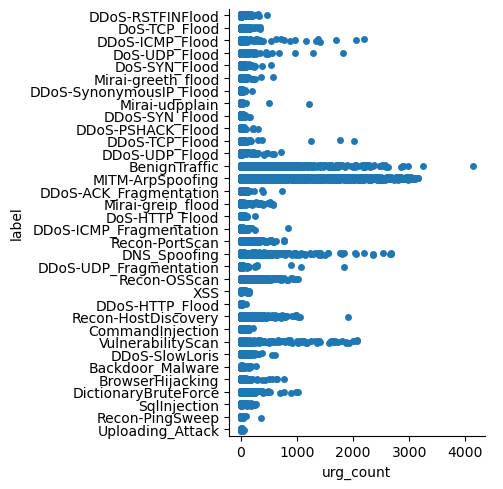

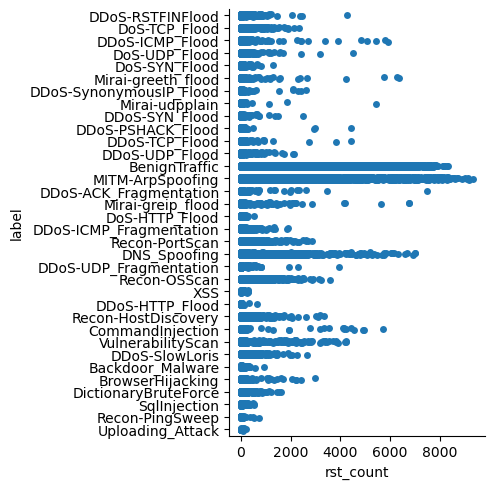

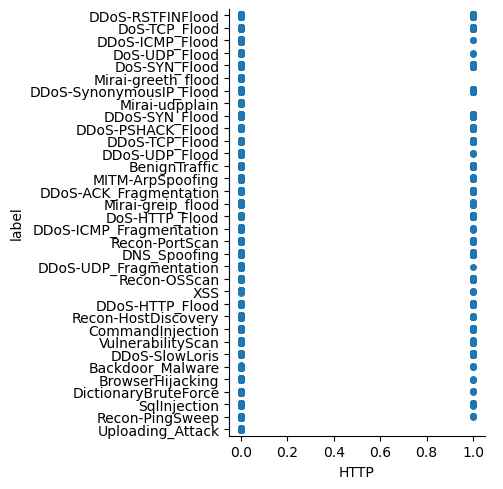

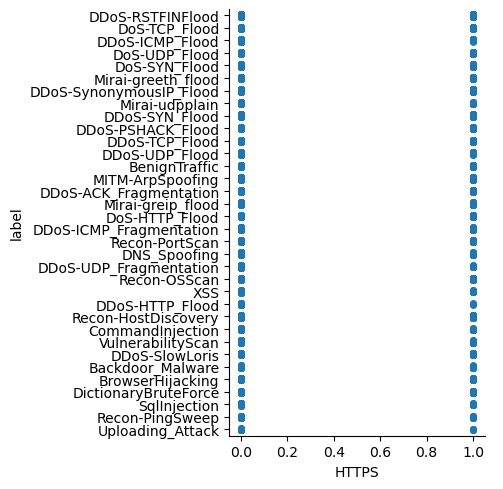

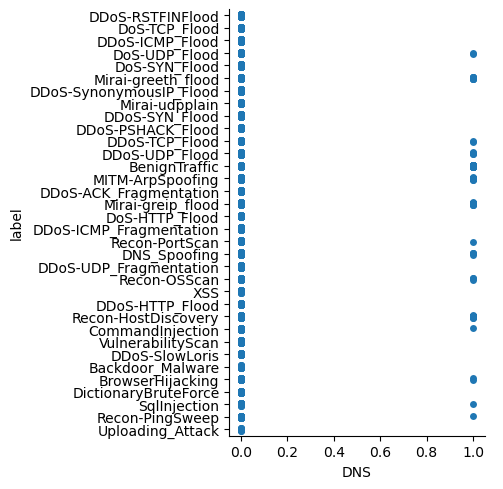

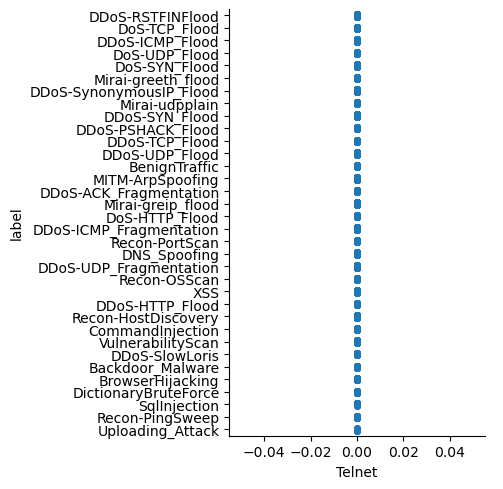

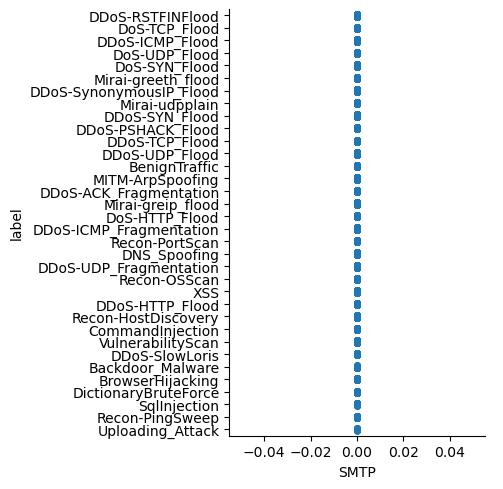

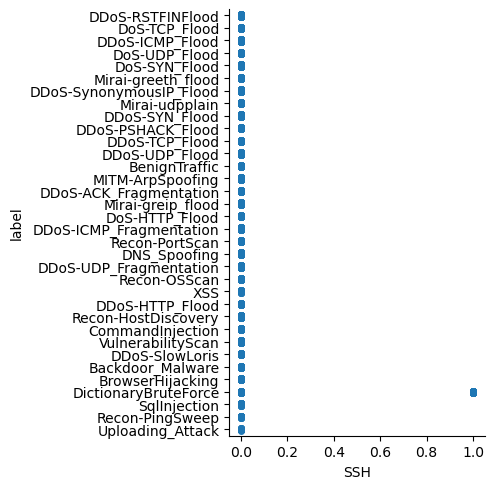

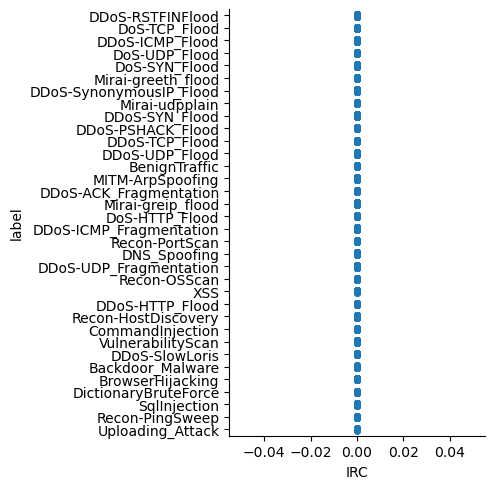

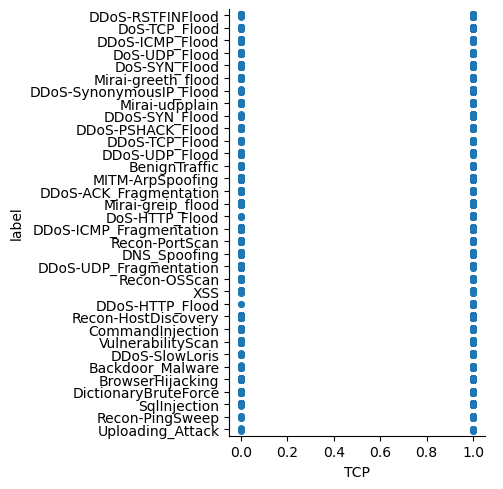

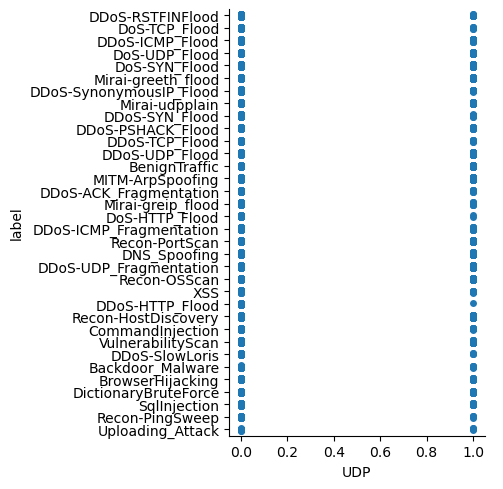

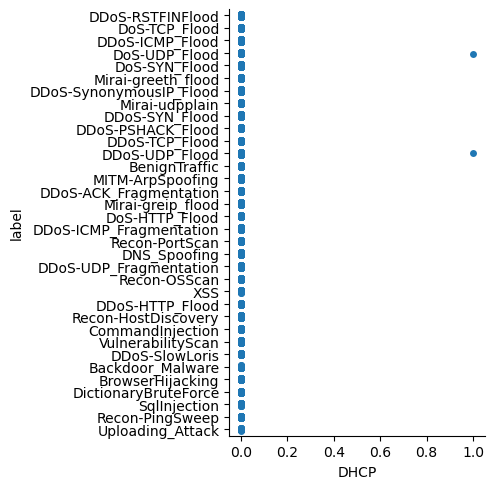

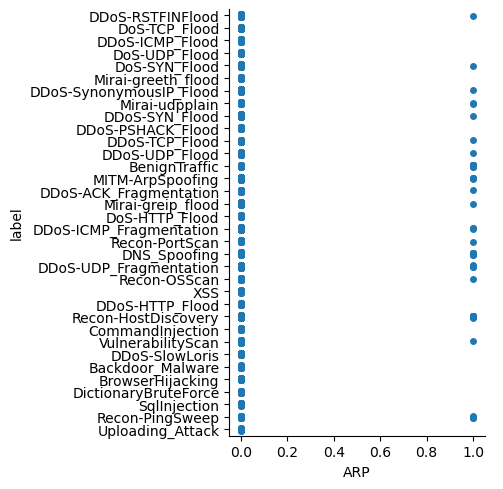

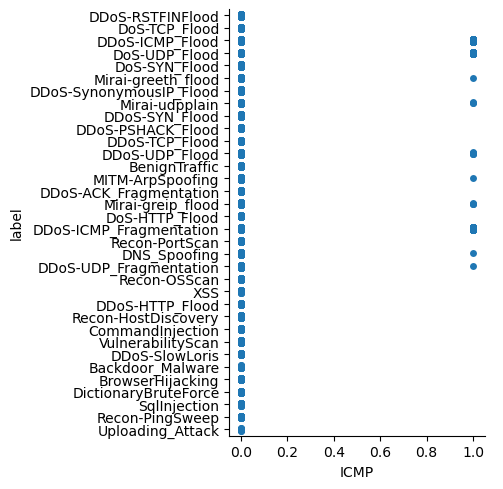

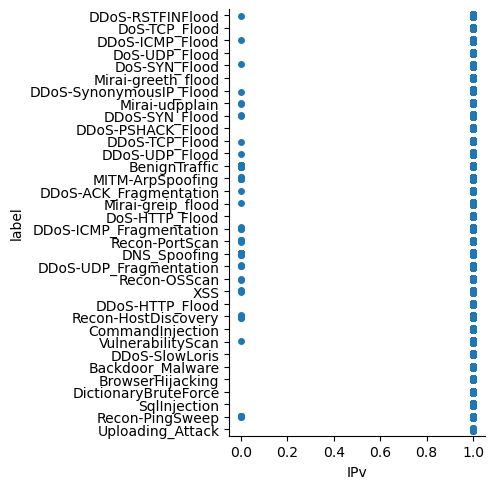

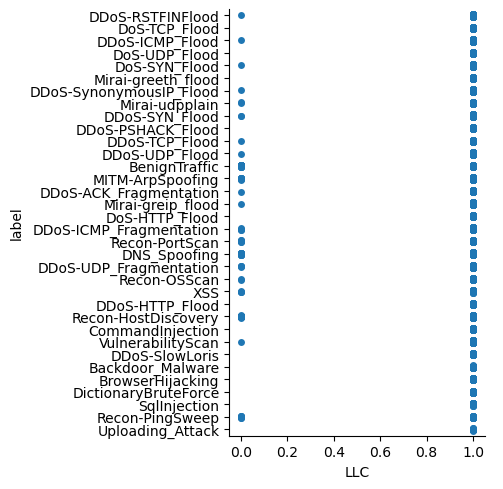

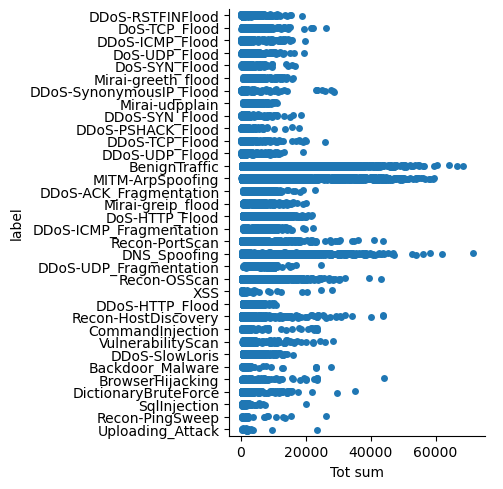

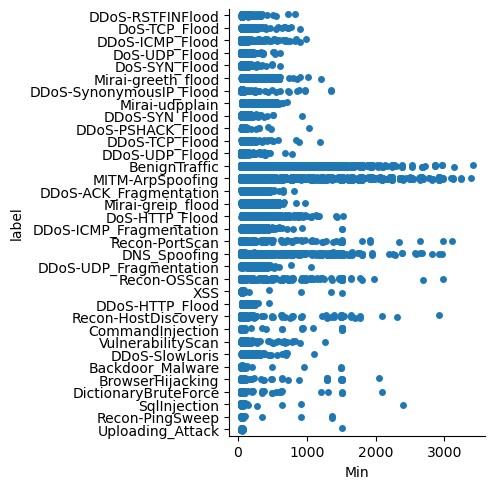

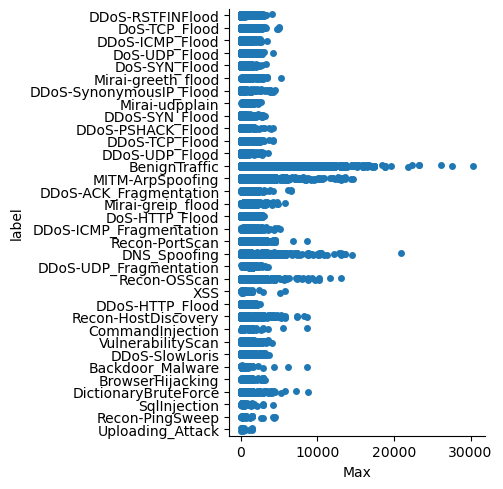

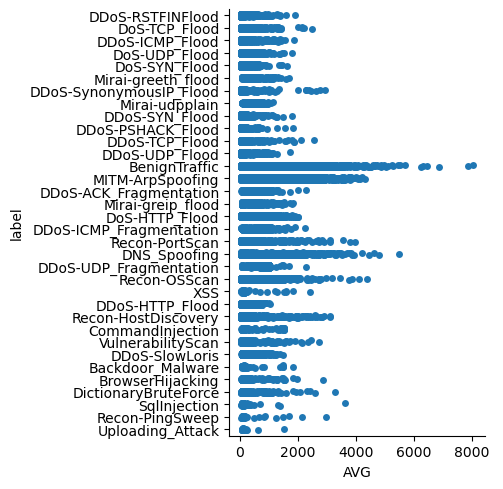

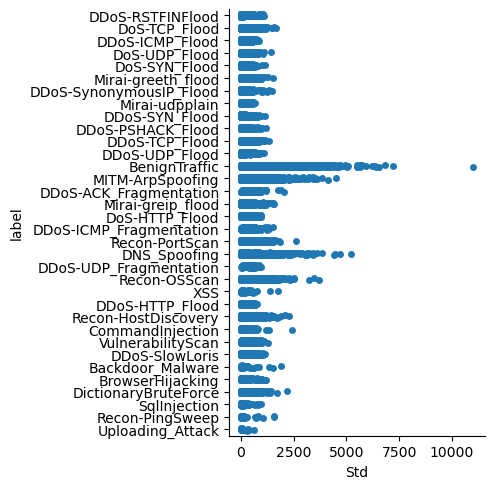

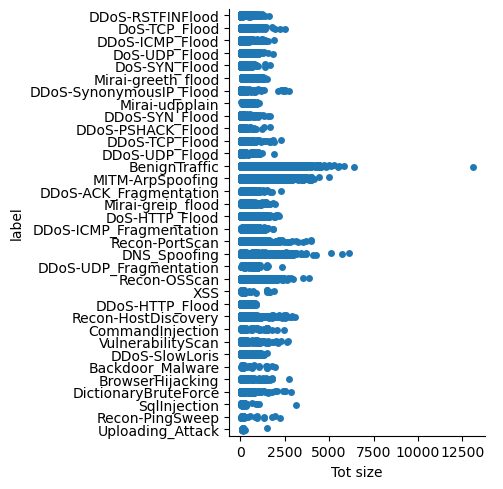

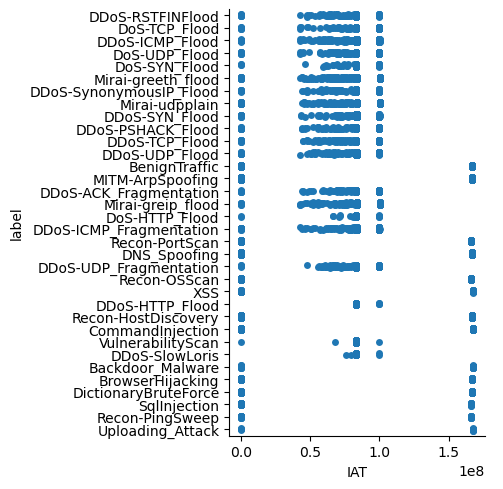

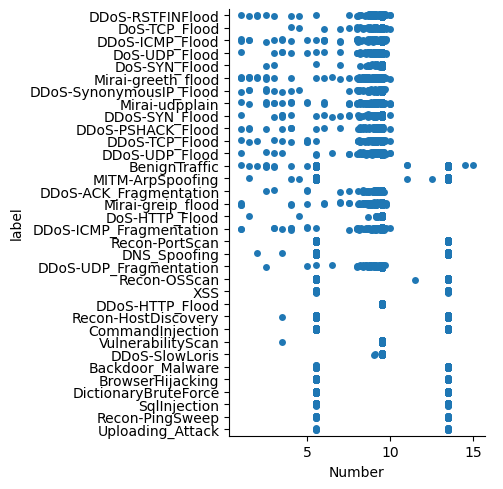

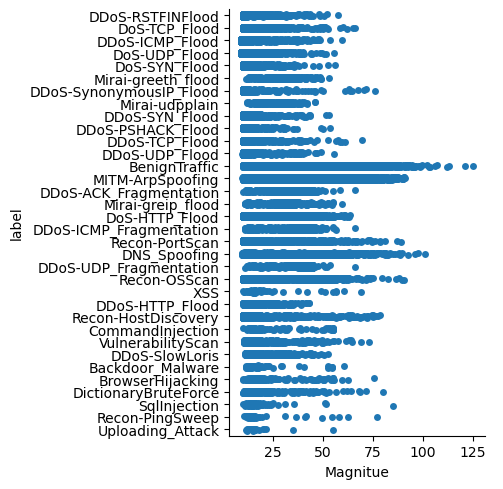

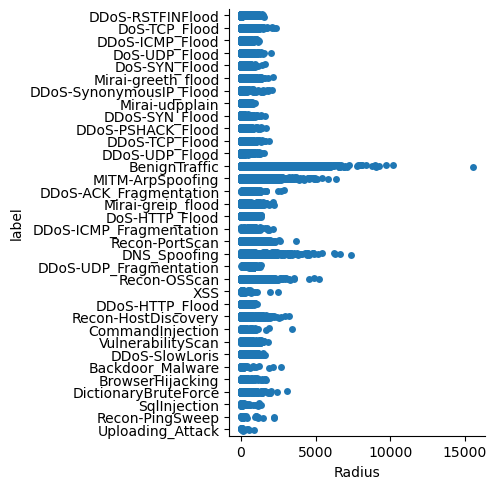

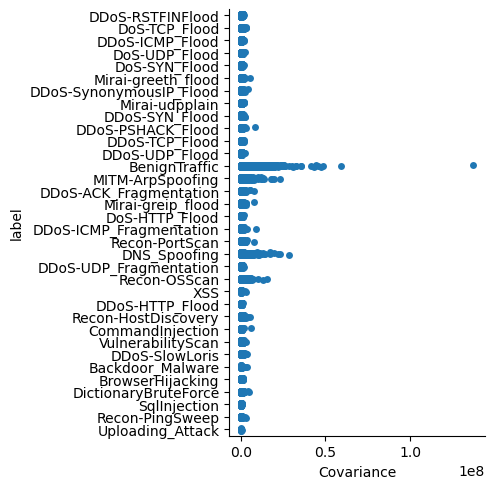

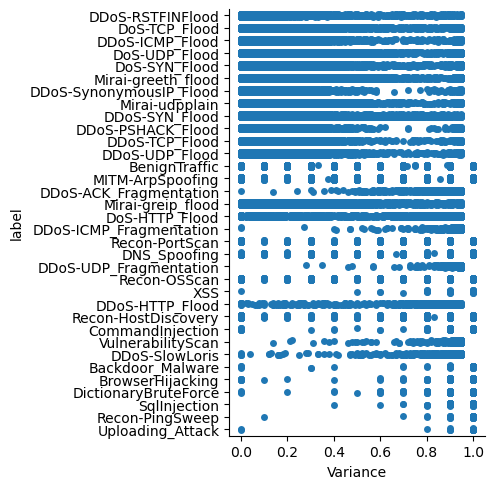

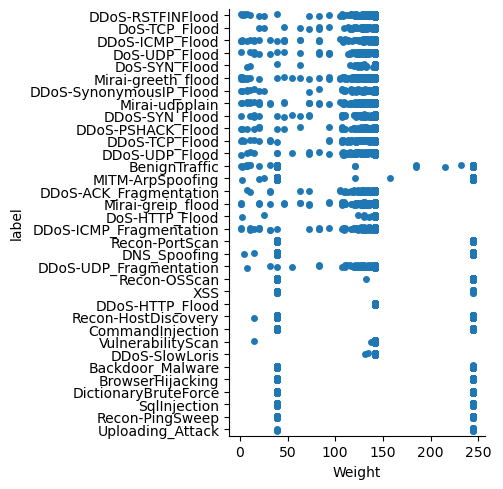

In [16]:
# create catplots showing distributions of outputs against all inputs
# (used for-loop because creating one pairplot used too much memory)
for name in intru_table.columns:
    if name not in ['label']:
        sns.catplot(data=intru_table, x=name, y='label')

## Fitting the Initial Model and Measuring Its Performance

In [17]:
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)



Epoch 1/50

29492/29492 [==============================] - 81s 3ms/step - loss: 0.7478
Epoch 2/50
29492/29492 [==============================] - 79s 3ms/step - loss: 0.5370
Epoch 3/50
29492/29492 [==============================] - 69s 2ms/step - loss: 0.5020
Epoch 4/50
29492/29492 [==============================] - 74s 2ms/step - loss: 0.4888
Epoch 5/50
29492/29492 [==============================] - 76s 3ms/step - loss: 0.4824
Epoch 6/50
29492/29492 [==============================] - 72s 2ms/step - loss: 0.4780
Epoch 7/50
29492/29492 [==============================] - 77s 3ms/step - loss: 0.4744
Epoch 8/50
29492/29492 [==============================] - 76s 3ms/step - loss: 0.4714
Epoch 9/50
29492/29492 [==============================] - 75s 3ms/step - loss: 0.4690
Epoch 10/50
29492/29492 [==============================] - 71s 2ms/step - loss: 0.4669
Epoch 11/50
29492/29492 [==============================] - 78s 3ms/step - loss: 0.4649
Epoch 12/50
29492/29492 [========================

In [18]:
# INITIAL STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 101s 3ms/step
Model Training Accuracy (avg.): 0.7859835098869682
Model Training Precision (avg.): 0.6106376168257833
Model Training Recall (avg.): 0.46039651525372266
Model Training MSE: 0.011884046245419163
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.83      0.73      0.78     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.70      0.51      0.59       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood      

In [19]:
# K-fold cross validation to generalize initial model performance (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    yhat_pred_test = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], yhat_pred_test)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], yhat_pred_test)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3277/3277 [==============================] - 11s 3ms/step
	Iteration 1 Accuracy: 0.6926033302180091
	Iteration 1 MSE: 0.016283085360257514
3277/3277 [==============================] - 11s 3ms/step
	Iteration 2 Accuracy: 0.767609529077419
	Iteration 2 MSE: 0.012699808031702257
3277/3277 [==============================] - 11s 3ms/step
	Iteration 3 Accuracy: 0.7688874477865304
	Iteration 3 MSE: 0.012645112213379888
3277/3277 [==============================] - 10s 3ms/step
	Iteration 4 Accuracy: 0.7648343474031547
	Iteration 4 MSE: 0.012716076531510963
3277/3277 [==============================] - 11s 3ms/step
	Iteration 5 Accuracy: 0.6997463235995346
	Iteration 5 MSE: 0.013544928547626877
3277/3277 [==============================] - 11s 3ms/step
	Iteration 6 Accuracy: 0.7747694479147792
	Iteration 6 MSE: 0.012402324959089944
3277/3277 [==============================] - 11s 3ms/step
	Iteration 7 Accuracy: 0.7107584615237895
	Iteration 7 MSE: 0.013231184879799887
3277/3277 [=================

## Identifying the Initial Model's Fitting Characteristics

In [20]:
# LOW1 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 16, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 109s 4ms/step - loss: 0.7595
Epoch 2/50
29492/29492 [==============================] - 104s 4ms/step - loss: 0.5498
Epoch 3/50
29492/29492 [==============================] - 104s 4ms/step - loss: 0.5197
Epoch 4/50
29492/29492 [==============================] - 102s 3ms/step - loss: 0.5002
Epoch 5/50
29492/29492 [==============================] - 102s 3ms/step - loss: 0.4883
Epoch 6/50
29492/29492 [==============================] - 109s 4ms/step - loss: 0.4812
Epoch 7/50
29492/29492 [==============================] - 89s 3ms/step - loss: 0.4769
Epoch 8/50
29492/29492 [==============================] - 98s 3ms/step - loss: 0.4738
Epoch 9/50
29492/29492 [==============================] - 98s 3ms/step - loss: 0.4710
Epoch 10/50
29492/29492 [==============================] - 113s 4ms/step - loss: 0.4684
Epoch 11/50
29492/29492 [==============================] - 110s 4ms/step - loss: 0.4663
Epoch 12/50
29492/29492 [===================

In [21]:
# LOW1 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
low1_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", low1_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
low1_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", low1_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 63s 2ms/step
Model Training Accuracy (avg.): 0.8092002157426432
Model Training Precision (avg.): 0.5746446592791007
Model Training Recall (avg.): 0.4469498419382303
Model Training MSE: 0.01073695510287886
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.72      0.93      0.81     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.68      0.34      0.45       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.98      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       0.

In [22]:
# LOW2 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 26, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 25, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 72s 2ms/step - loss: 0.7489
Epoch 2/50
29492/29492 [==============================] - 88s 3ms/step - loss: 0.5466
Epoch 3/50
29492/29492 [==============================] - 84s 3ms/step - loss: 0.5154
Epoch 4/50
29492/29492 [==============================] - 88s 3ms/step - loss: 0.4948
Epoch 5/50
29492/29492 [==============================] - 84s 3ms/step - loss: 0.4842
Epoch 6/50
29492/29492 [==============================] - 81s 3ms/step - loss: 0.4780
Epoch 7/50
29492/29492 [==============================] - 83s 3ms/step - loss: 0.4736
Epoch 8/50
29492/29492 [==============================] - 83s 3ms/step - loss: 0.4706
Epoch 9/50
29492/29492 [==============================] - 80s 3ms/step - loss: 0.4680
Epoch 10/50
29492/29492 [==============================] - 84s 3ms/step - loss: 0.4658
Epoch 11/50
29492/29492 [==============================] - 84s 3ms/step - loss: 0.4635
Epoch 12/50
29492/29492 [===========================

In [23]:
# LOW2 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
low2_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", low2_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
low2_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", low2_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 86s 3ms/step
Model Training Accuracy (avg.): 0.7924610873810687
Model Training Precision (avg.): 0.6199608079482811
Model Training Recall (avg.): 0.4632173277220639
Model Training MSE: 0.011708613543105427
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.76      0.88      0.82     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.66      0.47      0.55       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       0

In [24]:
# HIGH1 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 46, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 45, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 97s 3ms/step - loss: 0.7238
Epoch 2/50
29492/29492 [==============================] - 96s 3ms/step - loss: 0.5292
Epoch 3/50
29492/29492 [==============================] - 96s 3ms/step - loss: 0.4966
Epoch 4/50
29492/29492 [==============================] - 97s 3ms/step - loss: 0.4835
Epoch 5/50
29492/29492 [==============================] - 102s 3ms/step - loss: 0.4771
Epoch 6/50
29492/29492 [==============================] - 99s 3ms/step - loss: 0.4730
Epoch 7/50
29492/29492 [==============================] - 101s 3ms/step - loss: 0.4700
Epoch 8/50
29492/29492 [==============================] - 101s 3ms/step - loss: 0.4674
Epoch 9/50
29492/29492 [==============================] - 98s 3ms/step - loss: 0.4653
Epoch 10/50
29492/29492 [==============================] - 53s 2ms/step - loss: 0.4633
Epoch 11/50
29492/29492 [==============================] - 69s 2ms/step - loss: 0.4613
Epoch 12/50
29492/29492 [========================

In [25]:
# HIGH1 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
high1_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", high1_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
high1_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", high1_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 58s 2ms/step
Model Training Accuracy (avg.): 0.7974223204625963
Model Training Precision (avg.): 0.6274265647888362
Model Training Recall (avg.): 0.4701099482989651
Model Training MSE: 0.01139486669389733
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.76      0.91      0.83     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5796
        DDoS-HTTP_Flood       0.72      0.43      0.54       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       0.

In [26]:
# HIGH2 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 56, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 55, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 76s 3ms/step - loss: 0.7097
Epoch 2/50
29492/29492 [==============================] - 75s 3ms/step - loss: 0.5250
Epoch 3/50
29492/29492 [==============================] - 75s 3ms/step - loss: 0.4943
Epoch 4/50
29492/29492 [==============================] - 75s 3ms/step - loss: 0.4817
Epoch 5/50
29492/29492 [==============================] - 77s 3ms/step - loss: 0.4759
Epoch 6/50
29492/29492 [==============================] - 76s 3ms/step - loss: 0.4718
Epoch 7/50
29492/29492 [==============================] - 94s 3ms/step - loss: 0.4689
Epoch 8/50
29492/29492 [==============================] - 74s 3ms/step - loss: 0.4662
Epoch 9/50
29492/29492 [==============================] - 75s 3ms/step - loss: 0.4639
Epoch 10/50
29492/29492 [==============================] - 95s 3ms/step - loss: 0.4615
Epoch 11/50
29492/29492 [==============================] - 78s 3ms/step - loss: 0.4589
Epoch 12/50
29492/29492 [===========================

In [27]:
# HIGH2 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
high2_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", high2_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
high2_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", high2_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 57s 2ms/step
Model Training Accuracy (avg.): 0.8088780852734453
Model Training Precision (avg.): 0.6372996023121572
Model Training Recall (avg.): 0.4945649802323628
Model Training MSE: 0.010841142618216367
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.73      0.94      0.82     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5796
        DDoS-HTTP_Flood       0.71      0.40      0.52       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       0

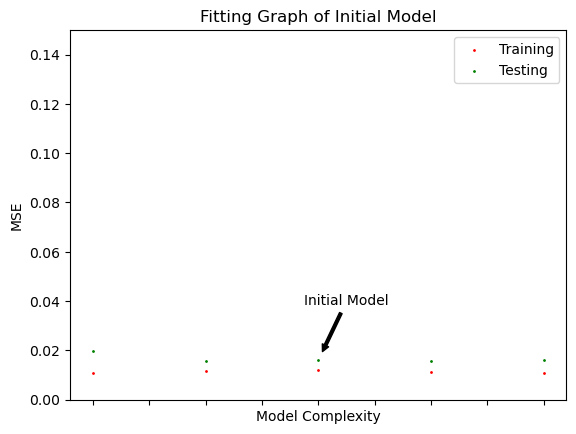

In [28]:
complexities = [1, 2, 3, 4, 5]
train_mse = [low1_MSE_train, low2_MSE_train, initial_MSE_train, high1_MSE_train, high2_MSE_train]
test_mse = [low1_MSE_test, low2_MSE_test, initial_MSE_test, high1_MSE_test, high2_MSE_test]
plt.scatter(complexities, train_mse, s = 1, c='r', label='Training')
plt.scatter(complexities, test_mse, s = 1, c='g', label='Testing')
plt.xlabel('Model Complexity')
plt.xticks(visible=False)
plt.ylim(0, 0.15)
plt.ylabel('MSE')
plt.title('Fitting Graph of Initial Model')
plt.annotate('Initial Model', (complexities[2], test_mse[2]), textcoords='offset points', xytext=(-10, 40),
             arrowprops=dict(arrowstyle='simple', facecolor='black', shrinkB=7))
plt.legend()
plt.show()

## Improving the Initial Model

### Revision 1: Removing Undersampled Output Classes

In [29]:
# create new table with most significantly undersampled classes removed
# classes removed: 'Uploading_Attack' (23 samples), 'Recon-PingSweep' (41 samples), 'XSS' (72 samples), 'Backdoor_Malware' (76 samples),
# 'CommandInjection' (105 samples), 'SqlInjection' (122 samples), 'BrowserHijacking' (140 samples)
undersampled_classes = ['Uploading_Attack', 'Recon-PingSweep', 'XSS', 'Backdoor_Malware', 'CommandInjection', 'SqlInjection', 'BrowserHijacking']
reduced_intru_table = intru_table.loc[~intru_table['label'].isin(undersampled_classes)]
reduced_intru_labels_removed = reduced_intru_table.drop(columns=['label'])
reduced_intru_label_names = ['BenignTraffic', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood',
                             'DDoS-ICMP_Fragmentation', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood',
                             'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation', 'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood',
                             'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain', 'Recon-HostDiscovery',
                             'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan']
attribute_data = reduced_intru_labels_removed.drop(columns=exclude)

# complete one-hot encoding on reduced intrusion labels
ohe = OneHotEncoder()
ohe_reduced_intru_labels = pd.DataFrame(ohe.fit_transform(reduced_intru_table['label'].values.reshape(-1,1)).toarray(), columns=reduced_intru_label_names)

# create normalized train and test sets for reduced data
X_train, X_test, y_train, y_test = train_test_split(attribute_data, ohe_reduced_intru_labels, train_size=0.9, random_state=5)
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=attribute_data.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=attribute_data.columns)

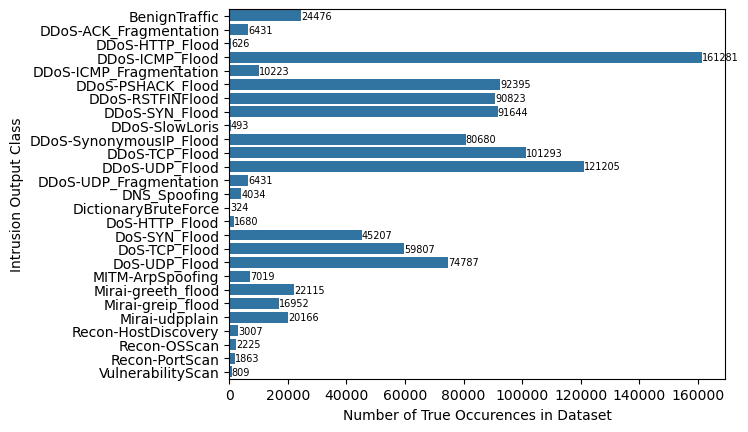

In [30]:
# show output class distribution of new dataset with undersampled classes removed
classes_true_count = []
for col in ohe_reduced_intru_labels:
    count = (ohe_reduced_intru_labels[col] == 1).sum()
    classes_true_count.append(count)
class_distru = pd.DataFrame({'Intrusion Output Class': ohe_reduced_intru_labels.columns, 'Number of True Occurences in Dataset': classes_true_count})
fig, ax = plt.subplots()
sns.barplot(x='Number of True Occurences in Dataset', y='Intrusion Output Class', data=class_distru)
for i in ax.containers:
    ax.bar_label(i, fontsize=7)

In [31]:
# K-fold cross validation to generalize revised model performance with fewer classes, same input/hidden structure as initial (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_reduced_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    yhat_pred_test = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], yhat_pred_test)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], yhat_pred_test)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3275/3275 [==============================] - 7s 2ms/step
	Iteration 1 Accuracy: 0.6686641221374046
	Iteration 1 MSE: 0.01808312128922816
3275/3275 [==============================] - 5s 2ms/step
	Iteration 2 Accuracy: 0.7667461832061069
	Iteration 2 MSE: 0.016130901894260672
3275/3275 [==============================] - 7s 2ms/step
	Iteration 3 Accuracy: 0.7598950381679389
	Iteration 3 MSE: 0.016440839694656487
3275/3275 [==============================] - 6s 2ms/step
	Iteration 4 Accuracy: 0.7593606870229007
	Iteration 4 MSE: 0.01649173027989822
3275/3275 [==============================] - 6s 2ms/step
	Iteration 5 Accuracy: 0.7666984732824428
	Iteration 5 MSE: 0.01602629346904156
3275/3275 [==============================] - 7s 2ms/step
	Iteration 6 Accuracy: 0.7663835877862596
	Iteration 6 MSE: 0.016055626236923946
3275/3275 [==============================] - 6s 2ms/step
	Iteration 7 Accuracy: 0.7699119266405213
	Iteration 7 MSE: 0.015862464053763587
3275/3275 [==========================

### Revision 2: Adding Another Hidden Layer, More Nodes for the Reduced Dataset

In [32]:
# K-fold cross validation to generalize revision 2 model (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 50, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 45, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_reduced_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    yhat_pred_test = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], yhat_pred_test)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], yhat_pred_test)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3275/3275 [==============================] - 7s 2ms/step
	Iteration 1 Accuracy: 0.734675572519084
	Iteration 1 MSE: 0.016673734803505796
3275/3275 [==============================] - 7s 2ms/step
	Iteration 2 Accuracy: 0.7679007633587787
	Iteration 2 MSE: 0.015652389030251627
3275/3275 [==============================] - 7s 2ms/step
	Iteration 3 Accuracy: 0.7770038167938931
	Iteration 3 MSE: 0.01564567430025445
3275/3275 [==============================] - 7s 2ms/step
	Iteration 4 Accuracy: 0.7870896946564886
	Iteration 4 MSE: 0.015183771557817359
3275/3275 [==============================] - 7s 2ms/step
	Iteration 5 Accuracy: 0.7803339694656488
	Iteration 5 MSE: 0.015516680802940346
3275/3275 [==============================] - 7s 2ms/step
	Iteration 6 Accuracy: 0.7857729007633588
	Iteration 6 MSE: 0.015181297709923661
3275/3275 [==============================] - 7s 2ms/step
	Iteration 7 Accuracy: 0.7824120459164686
	Iteration 7 MSE: 0.015363802241539623
3275/3275 [=========================

In [33]:
# K-fold showed improvements in generalized model - train actual Revision 2 model
classifier = Sequential()
classifier.add(Dense(units = 50, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 45, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train, y_train, epochs = 50)

Epoch 1/50
29475/29475 [==============================] - 76s 3ms/step - loss: 0.7020
Epoch 2/50
29475/29475 [==============================] - 71s 2ms/step - loss: 0.5130
Epoch 3/50
29475/29475 [==============================] - 75s 3ms/step - loss: 0.4834
Epoch 4/50
29475/29475 [==============================] - 75s 3ms/step - loss: 0.4730
Epoch 5/50
29475/29475 [==============================] - 71s 2ms/step - loss: 0.4665
Epoch 6/50
29475/29475 [==============================] - 71s 2ms/step - loss: 0.4615
Epoch 7/50
29475/29475 [==============================] - 71s 2ms/step - loss: 0.4576
Epoch 8/50
29475/29475 [==============================] - 73s 2ms/step - loss: 0.4550
Epoch 9/50
29475/29475 [==============================] - 71s 2ms/step - loss: 0.4528
Epoch 10/50
29475/29475 [==============================] - 72s 2ms/step - loss: 0.4507
Epoch 11/50
29475/29475 [==============================] - 69s 2ms/step - loss: 0.4490
Epoch 12/50
29475/29475 [===========================

In [34]:
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

29475/29475 [==============================] - 61s 2ms/step
Model Training Accuracy (avg.): 0.8118789731932705
Model Training Precision (avg.): 0.7953606357561137
Model Training Recall (avg.): 0.6297635298009493
Model Training MSE: 0.013543981982143297
                         precision    recall  f1-score   support

          BenignTraffic       0.75      0.94      0.83     22114
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5791
        DDoS-HTTP_Flood       0.67      0.50      0.57       563
        DDoS-ICMP_Flood       1.00      1.00      1.00    145320
DDoS-ICMP_Fragmentation       1.00      0.98      0.99      9222
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83179
       DDoS-RSTFINFlood       1.00      1.00      1.00     81736
         DDoS-SYN_Flood       0.67      0.96      0.79     82639
         DDoS-SlowLoris       0.68      0.22      0.34       451
DDoS-SynonymousIP_Flood       0.89      0.59      0.71     72428
         DDoS-TCP_Flood       0

### Revision 3: Adding Even More Layers and Nodes

In [35]:
# K-fold cross validation to generalize revision 3 model (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 70, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 60, activation = 'relu'))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 30, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_reduced_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    yhat_pred_test = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], yhat_pred_test)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], yhat_pred_test)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3275/3275 [==============================] - 7s 2ms/step
	Iteration 1 Accuracy: 0.7663549618320611
	Iteration 1 MSE: 0.016211478654226747
3275/3275 [==============================] - 7s 2ms/step
	Iteration 2 Accuracy: 0.7693225190839694
	Iteration 2 MSE: 0.016034421826406558
3275/3275 [==============================] - 7s 2ms/step
	Iteration 3 Accuracy: 0.7813454198473282
	Iteration 3 MSE: 0.015383093016680801
3275/3275 [==============================] - 7s 2ms/step
	Iteration 4 Accuracy: 0.7832347328244275
	Iteration 4 MSE: 0.01536153519932146
3275/3275 [==============================] - 7s 2ms/step
	Iteration 5 Accuracy: 0.7812977099236641
	Iteration 5 MSE: 0.015626236923946848
3275/3275 [==============================] - 7s 2ms/step
	Iteration 6 Accuracy: 0.7874904580152672
	Iteration 6 MSE: 0.015198968052021486
3275/3275 [==============================] - 8s 2ms/step
	Iteration 7 Accuracy: 0.791524728289392
	Iteration 7 MSE: 0.014804353872474751
3275/3275 [=========================

In [36]:
# K-fold showed improvements in generalized model - train actual Revision 3 model
classifier = Sequential()
classifier.add(Dense(units = 70, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 60, activation = 'relu'))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 30, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train, y_train, epochs = 50)

Epoch 1/50
29475/29475 [==============================] - 79s 3ms/step - loss: 0.6253
Epoch 2/50
29475/29475 [==============================] - 80s 3ms/step - loss: 0.4852
Epoch 3/50
29475/29475 [==============================] - 82s 3ms/step - loss: 0.4684
Epoch 4/50
29475/29475 [==============================] - 86s 3ms/step - loss: 0.4600
Epoch 5/50
29475/29475 [==============================] - 1787s 61ms/step - loss: 0.4553
Epoch 6/50
29475/29475 [==============================] - 83s 3ms/step - loss: 0.4518
Epoch 7/50
29475/29475 [==============================] - 84s 3ms/step - loss: 0.4490
Epoch 8/50
29475/29475 [==============================] - 77s 3ms/step - loss: 0.4471
Epoch 9/50
29475/29475 [==============================] - 79s 3ms/step - loss: 0.4450
Epoch 10/50
29475/29475 [==============================] - 82s 3ms/step - loss: 0.4436
Epoch 11/50
29475/29475 [==============================] - 80s 3ms/step - loss: 0.4419
Epoch 12/50
29475/29475 [========================

In [37]:
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

29475/29475 [==============================] - 85s 3ms/step
Model Training Accuracy (avg.): 0.8017294390561452
Model Training Precision (avg.): 0.7584607699272119
Model Training Recall (avg.): 0.6196094861563205
Model Training MSE: 0.014229319289985365
                         precision    recall  f1-score   support

          BenignTraffic       0.77      0.92      0.84     22114
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      5791
        DDoS-HTTP_Flood       0.61      0.67      0.64       563
        DDoS-ICMP_Flood       1.00      1.00      1.00    145320
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9222
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83179
       DDoS-RSTFINFlood       1.00      1.00      1.00     81736
         DDoS-SYN_Flood       0.67      0.95      0.79     82639
         DDoS-SlowLoris       0.73      0.29      0.41       451
DDoS-SynonymousIP_Flood       0.89      0.57      0.70     72428
         DDoS-TCP_Flood       0

### Revision 4: Adding More Nodes, Changing from Descending Structure to Pyramid Node Structure (Same Number of Hidden Layers)

In [38]:
# K-fold cross validation to generalize revision 4 model (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 60, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 80, activation = 'relu'))
classifier.add(Dense(units = 100, activation = 'relu'))
classifier.add(Dense(units = 75, activation = 'relu'))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_reduced_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    yhat_pred_test = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], yhat_pred_test)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], yhat_pred_test)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3275/3275 [==============================] - 9s 3ms/step
	Iteration 1 Accuracy: 0.7674522900763359
	Iteration 1 MSE: 0.016347186881538026
3275/3275 [==============================] - 11s 3ms/step
	Iteration 2 Accuracy: 0.7819942748091603
	Iteration 2 MSE: 0.015434337008764487
3275/3275 [==============================] - 11s 3ms/step
	Iteration 3 Accuracy: 0.7845801526717557
	Iteration 3 MSE: 0.015104255018377154
3275/3275 [==============================] - 11s 3ms/step
	Iteration 4 Accuracy: 0.7861164122137405
	Iteration 4 MSE: 0.015297568560927337
3275/3275 [==============================] - 11s 3ms/step
	Iteration 5 Accuracy: 0.7856011450381679
	Iteration 5 MSE: 0.015189779474130619
3275/3275 [==============================] - 11s 3ms/step
	Iteration 6 Accuracy: 0.7787690839694656
	Iteration 6 MSE: 0.01582555838281029
3275/3275 [==============================] - 10s 3ms/step
	Iteration 7 Accuracy: 0.7858281090468421
	Iteration 7 MSE: 0.015302308864270331
3275/3275 [==================

In [39]:
# K-fold showed little to no improvements in generalized model - train actual Revision 4 model
classifier = Sequential()
classifier.add(Dense(units = 60, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 80, activation = 'relu'))
classifier.add(Dense(units = 100, activation = 'relu'))
classifier.add(Dense(units = 75, activation = 'relu'))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train, y_train, epochs = 50)

Epoch 1/50
29475/29475 [==============================] - 106s 4ms/step - loss: 0.6249
Epoch 2/50
29475/29475 [==============================] - 108s 4ms/step - loss: 0.4826
Epoch 3/50
29475/29475 [==============================] - 113s 4ms/step - loss: 0.4657
Epoch 4/50
29475/29475 [==============================] - 108s 4ms/step - loss: 0.4584
Epoch 5/50
29475/29475 [==============================] - 113s 4ms/step - loss: 0.4544
Epoch 6/50
29475/29475 [==============================] - 106s 4ms/step - loss: 0.4506
Epoch 7/50
29475/29475 [==============================] - 97s 3ms/step - loss: 0.4478
Epoch 8/50
29475/29475 [==============================] - 45403s 2s/step - loss: 0.4456
Epoch 9/50
29475/29475 [==============================] - 92s 3ms/step - loss: 0.4437
Epoch 10/50
29475/29475 [==============================] - 90s 3ms/step - loss: 0.4418
Epoch 11/50
29475/29475 [==============================] - 92s 3ms/step - loss: 0.4401
Epoch 12/50
29475/29475 [===================

In [40]:
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

29475/29475 [==============================] - 92s 3ms/step
Model Training Accuracy (avg.): 0.7962692801920279
Model Training Precision (avg.): 0.7953266559639209
Model Training Recall (avg.): 0.6118551574754811
Model Training MSE: 0.014413916246621219
                         precision    recall  f1-score   support

          BenignTraffic       0.81      0.85      0.83     22114
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      5791
        DDoS-HTTP_Flood       0.62      0.58      0.60       563
        DDoS-ICMP_Flood       1.00      1.00      1.00    145320
DDoS-ICMP_Fragmentation       1.00      0.98      0.99      9222
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83179
       DDoS-RSTFINFlood       1.00      1.00      1.00     81736
         DDoS-SYN_Flood       0.68      0.92      0.78     82639
         DDoS-SlowLoris       0.81      0.20      0.31       451
DDoS-SynonymousIP_Flood       0.74      0.73      0.73     72428
         DDoS-TCP_Flood       0

## Final Model and its Fitting Characteristics

Here is the code that generated our final model, which produced the best results out of all the revised models:

```classifier = Sequential()
classifier.add(Dense(units = 70, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 60, activation = 'relu'))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 30, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')

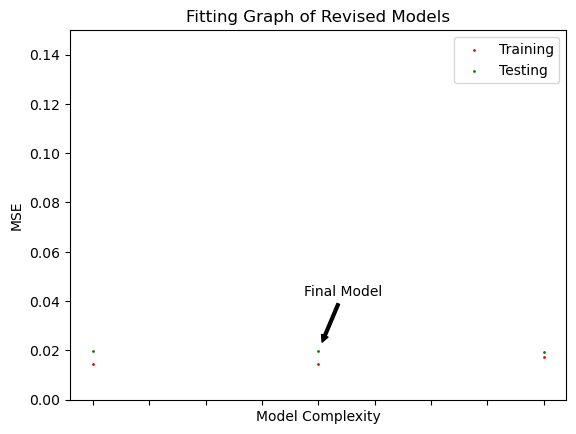

In [41]:
complexities = [1, 2, 3]
# Revision2, Revision3, Revision4 (final)
train_mse = [0.014385329438616347, 0.014464414371750703, 0.017478791180121554]
test_mse = [0.019767811704834607, 0.01966991800961266, 0.019265973989256432]
plt.scatter(complexities, train_mse, s = 1, c='r', label='Training')
plt.scatter(complexities, test_mse, s = 1, c='g', label='Testing')
plt.xlabel('Model Complexity')
plt.xticks(visible=False)
plt.ylim(0, 0.15)
plt.ylabel('MSE')
plt.title('Fitting Graph of Revised Models')
plt.annotate('Final Model', (complexities[1], test_mse[1]), textcoords='offset points', xytext=(-10, 40),
             arrowprops=dict(arrowstyle='simple', facecolor='black', shrinkB=7))
plt.legend()
plt.show()